In [1]:
import numpy as np
import torch
import deepchem as dc
from torch_geometric.data import Data, DataLoader
import pandas as pd

from rdkit import Chem
from rdkit.Chem import Draw

#check GPU
print('CUDA available: {}'.format(torch.cuda.is_available()))
print('Current GPU: {}'.format(torch.cuda.get_device_name(torch.cuda.current_device())))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

RDKit WARNING: [01:31:44] Enabling RDKit 2019.09.3 jupyter extensions


CUDA available: True
Current GPU: GeForce RTX 2080 SUPER


In [2]:
#cis_model = torch.load('trained_models/AFP_tl_cisplatin_0.9082')
cis_model = torch.load('trained_models/AFP_tl_cisplatin_test')
#amg_model = torch.load('trained_models/AFP_tl_amg_0.8836')
amg_model = torch.load('trained_models/AFP_tl_amg_test')

In [3]:
from featurizer import MolGraphConvFeaturizer

featurizer = MolGraphConvFeaturizer(
    use_edges=True, use_chirality=True, use_partial_charge=True
)

In [4]:
from rdkit import Chem
from utils import validate_mols
from copy import deepcopy

def get_valid_smiles(data):
    smiles = list(data['smiles'])
    mols = [Chem.MolFromSmiles(s) for s in smiles]
    valid_mols, valid_index = validate_mols(mols)
    valid_smiles = [Chem.MolToSmiles(mol) for mol in valid_mols]
    return valid_smiles, valid_index

def get_valid_mols(data):
    smiles = list(data['smiles'])
    mols = [Chem.MolFromSmiles(s) for s in smiles]
    valid_mols, valid_index = validate_mols(mols)
    return valid_mols, valid_index

def get_valid_features(molecules, featurizer):
    valid_features = []
    valid_index = []
    for i, mol in enumerate(molecules):
        try:
            valid_features.append(featurizer._featurize(mol))
            valid_index.append(i)
        except Exception as e:
            print("Failed to featurize datapoint %d, %s.", i, Chem.MolToSmiles(mol))
            print("Exception message: {}".format(e))

    return np.asarray(valid_features), np.array(valid_index)

def featurize_data(data, featurizer):
    valid_smiles, valid_index = get_valid_smiles(data)
    valid_mols, valid_index = get_valid_mols(data)
    valid_data = data.iloc[valid_index]
    valid_features, valid_index = get_valid_features(valid_mols, featurizer)
    valid_data = valid_data.iloc[valid_index]
    valid_data['smiles'] = valid_smiles
    return valid_features, valid_data

def get_fragmented_features(feature):
    num_nodes = feature.node_features.shape[0]
    
    fragmented_features = []
    for i in range(num_nodes):
        new_feature = deepcopy(feature)
        new_feature.node_features = np.delete(feature.node_features, i, axis=0)
        
        del_edge_idx = feature.edge_index == i
        del_edge_idx_comb = del_edge_idx[0, :] | del_edge_idx[1, :]
        
        new_edge_index = np.delete(
            feature.edge_index, del_edge_idx_comb, axis=1)
        new_edge_index[new_edge_index > i] -= 1
        
        new_feature.edge_index = new_edge_index
        new_feature.edge_features = np.delete(
            feature.edge_features, del_edge_idx_comb, axis=0)
        new_feature.num_nodes = new_feature.node_features.shape[0]
        new_feature.num_edges = new_feature.edge_index.shape[1]
        
        fragmented_features.append(new_feature)
        
    return np.asarray(fragmented_features)

def featurize_fragmented_data(data, featurizer):
    valid_smiles, valid_index = get_valid_smiles(data)
    valid_mols, valid_index = get_valid_mols(data)
    valid_data = data.iloc[valid_index]
    valid_features, valid_index = get_valid_features(valid_mols, featurizer)
    valid_data = valid_data.iloc[valid_index]
    valid_data['smiles'] = valid_smiles
    
    valid_fragmented_features = [get_fragmented_features(f) for f in valid_features]
    return valid_fragmented_features, valid_data

def predict(model, loader):
    model.eval()

    outs = []
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        outs.append(torch.sigmoid(out).detach().cpu().numpy())
    
    pred = np.concatenate(outs, axis=0)
    return pred

def check_training_data(train_dataset, res_data):
    for i in range(len(res_data)):
        curr_smiles = res_data.iloc[i]['smiles']
        for j, tr_smiles in enumerate(train_dataset.ids):
            if tr_smiles == curr_smiles:
                if train_dataset.y[j][0] == 1.:
                    res_data.iloc[i, 2] = -1.
                else:
                    res_data.iloc[i, 2] = -2.
    return res_data

In [5]:
from rdkit.Chem.Draw import SimilarityMaps
import matplotlib.pyplot as plt

def vis_contribs(ff_pred, pred, frag_end_idxs, df, num_vis=10):
    mols = [Chem.MolFromSmiles(s) for s in df['smiles']]
    idx_offsets = np.insert(frag_end_idxs, 0, 0)
    for i, mol in enumerate(mols[:num_vis]):
        wt = [pred[i] - ff_pred[idx_offsets[i] + n] 
              for n, atom in enumerate(mol.GetAtoms())]
        try:
            print(df['Name'].iloc[i])
        except:
            print(df['smiles'].iloc[i])
        print('score:{}'.format(np.squeeze(pred[i])))
        fig = SimilarityMaps.GetSimilarityMapFromWeights(mol, wt)
        plt.show()
        
    #return maps

In [6]:
_, amg_datasets, _ = dc.utils.load_dataset_from_disk('data/combined/amg')
amg_train_dataset, amg_valid_dataset, amg_test_dataset = amg_datasets

In [7]:
amg_data = pd.read_csv('data/tl/amg_data-210723.csv')
#amg_data = pd.read_csv('data/tl/amg_data_selected.csv')
valid_amg_fragmented_features, valid_amg_data = featurize_fragmented_data(
    amg_data, featurizer)
valid_amg_ff_concat = np.concatenate(valid_amg_fragmented_features)

amg_ff_loader = DataLoader([x.to_pyg_graph() for x in valid_amg_ff_concat], 
           batch_size=16, shuffle=False)
amg_ff_pred = predict(amg_model, amg_ff_loader)

amg_frag_lens = [len(f) for f in valid_amg_fragmented_features]
amg_frag_end_idxs = np.cumsum(amg_frag_lens)

valid_amg_features, valid_amg_data = featurize_data(
    amg_data, featurizer)

amg_loader = DataLoader([x.to_pyg_graph() for x in valid_amg_features], 
           batch_size=16, shuffle=False)
amg_pred = predict(amg_model, amg_loader)

Amsacrine
score:0.540341854095459


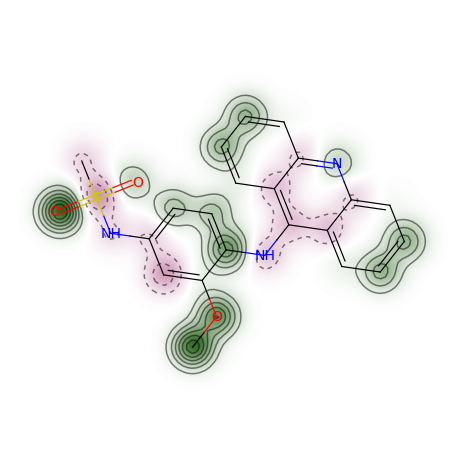

Carvedilol
score:0.8092871308326721


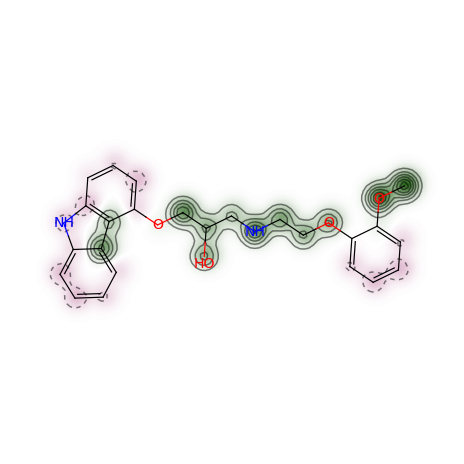

Cepharanthine
score:0.8584883213043213


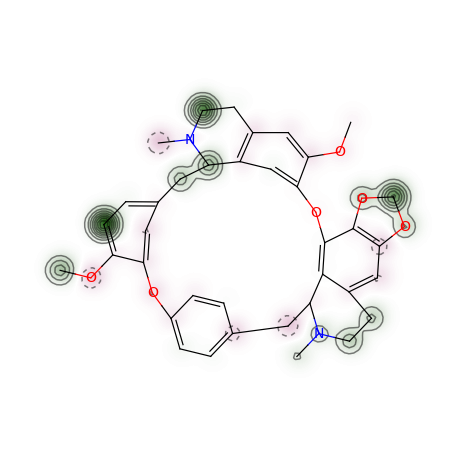

Drofenine
score:0.8774351477622986


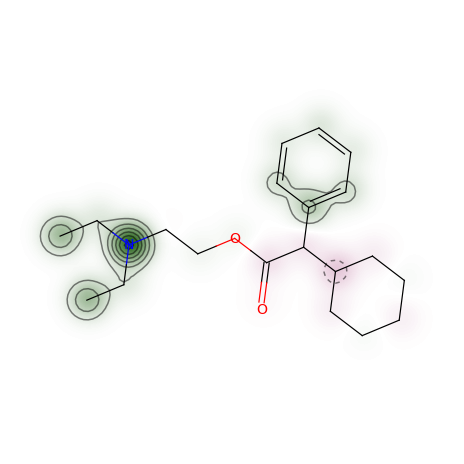

Hexamethyleneamiloride
score:0.6648769378662109


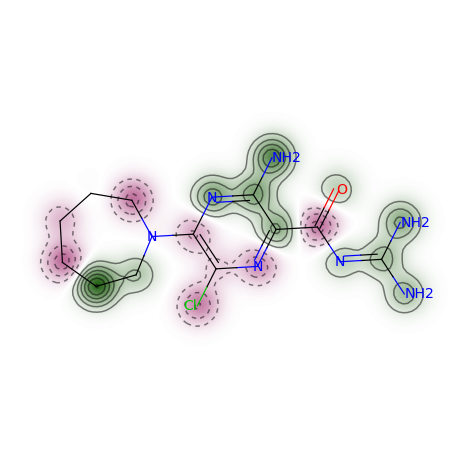

Phenoxybenzamine
score:0.8425888419151306


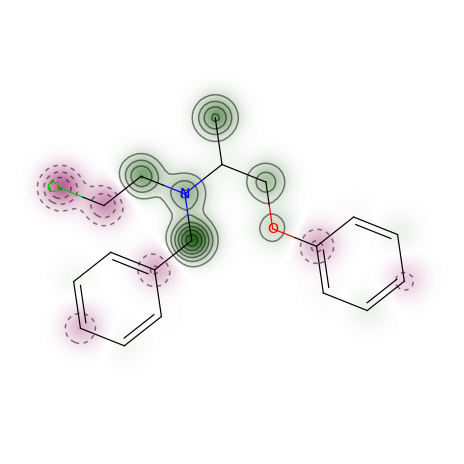

9-amino-1,2,3,4-.tetrahydroacridine (Tacrine)
score:0.822640061378479


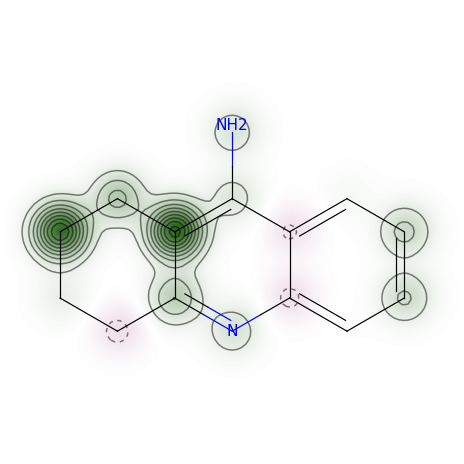

deferoxamine
score:0.4285760521888733


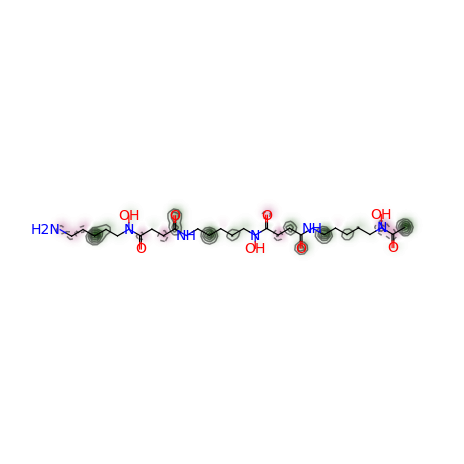

2.2′-dipyridyl
score:0.7921650409698486


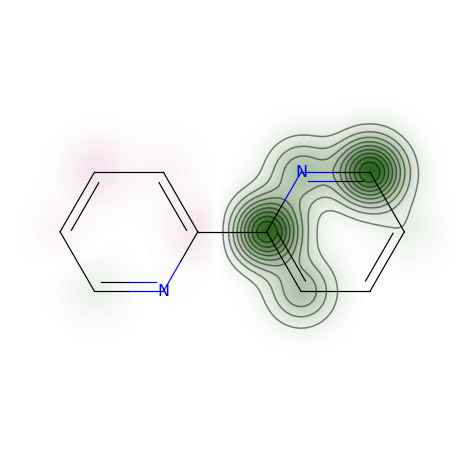

coenzyme Q10
score:0.9111924171447754


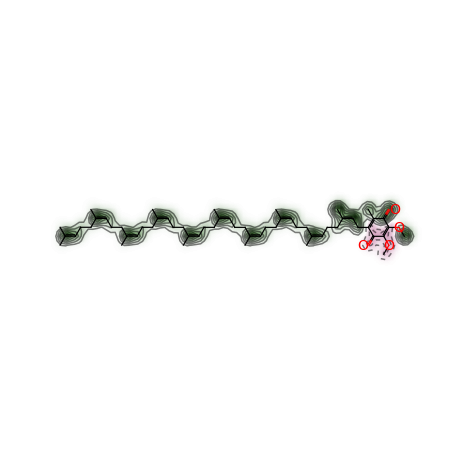

In [8]:
maps = vis_contribs(
    amg_ff_pred, 
    amg_pred, 
    amg_frag_end_idxs, 
    valid_amg_data,
    num_vis=10
)

In [9]:
#res_amg_data = valid_amg_data.copy()
#res_amg_data.insert(2, 'p', amg_pred)
#res_amg_data_sorted = res_amg_data.sort_values(by=['p'], ascending=False)
#check_training_data(amg_train_dataset, res_amg_data_sorted)

In [10]:
pos_data = pd.read_csv('data/tl/experiment_check_positive_data.csv')

valid_pos_ff, valid_pos_data = featurize_fragmented_data(
    pos_data, featurizer)
valid_pos_ff_concat = np.concatenate(valid_pos_ff)

pos_ff_loader = DataLoader([x.to_pyg_graph() for x in valid_pos_ff_concat], 
           batch_size=16, shuffle=False)

pos_frag_lens = [len(f) for f in valid_pos_ff]
pos_frag_end_idxs = np.cumsum(pos_frag_lens)

valid_pos_features, valid_pos_data = featurize_data(
    pos_data, featurizer)
pos_loader = DataLoader([x.to_pyg_graph() for x in valid_pos_features], 
           batch_size=16, shuffle=False)

In [11]:
pos_ff_amg_pred = predict(amg_model, pos_ff_loader)
pos_amg_pred = predict(amg_model, pos_loader)

Ammonium Lactate solution
score:0.8016087412834167


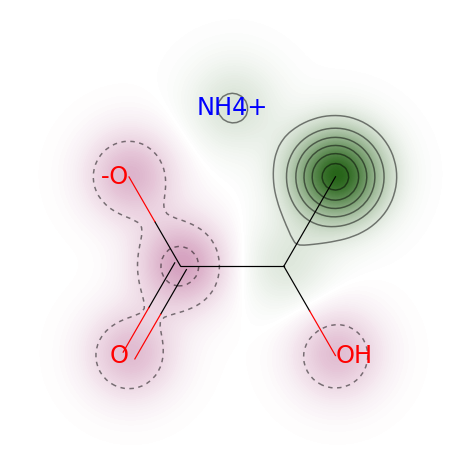

L-Glutamine
score:0.7276018261909485


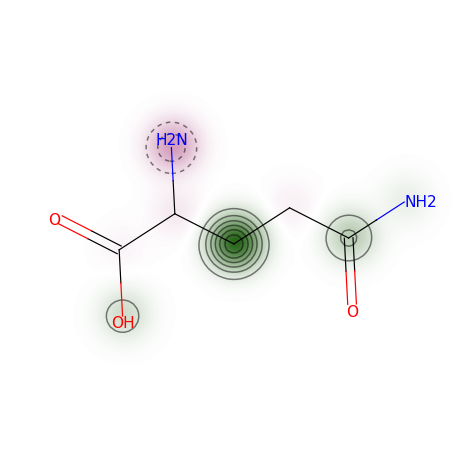

Malic Acid
score:0.6370066404342651


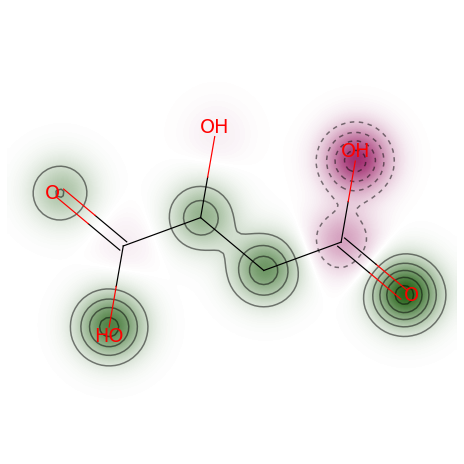

Dexpanthenol
score:0.8372825980186462


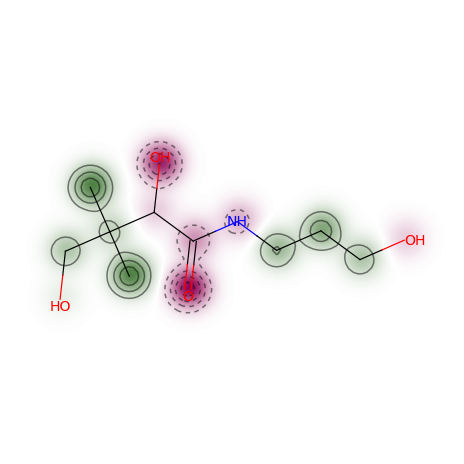

Midodrine Hydrochloride
score:0.8315679430961609


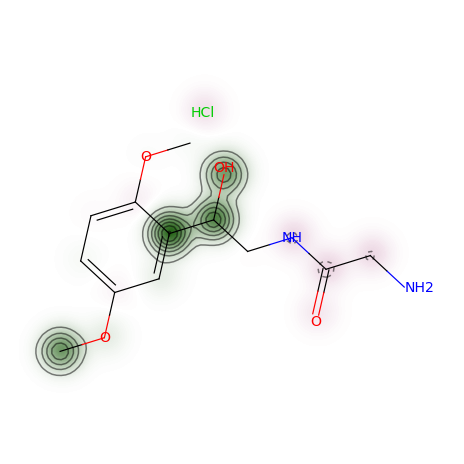

Calcium Citrate Tetrahydrate
score:0.6736946702003479


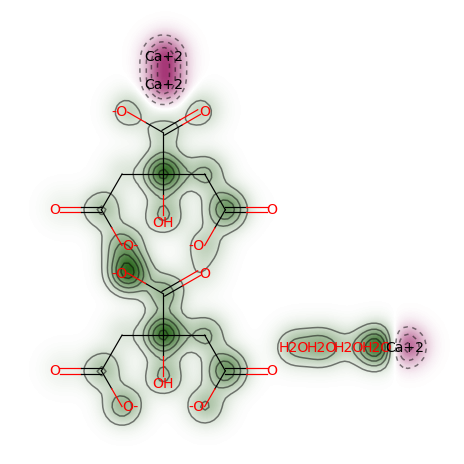

Strontium Ranelate
score:0.1114836260676384


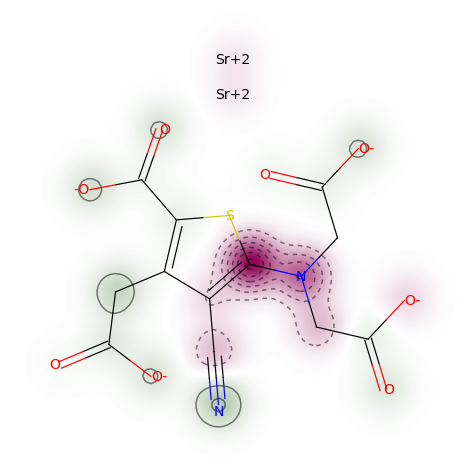

In [12]:
vis_contribs(
    pos_ff_amg_pred, 
    pos_amg_pred, 
    pos_frag_end_idxs, 
    valid_pos_data,
    num_vis=10
)

In [13]:
res_pos_amg_data = valid_pos_data.copy()
res_pos_amg_data.insert(2, 'p', pos_amg_pred)
res_pos_amg_data_sorted = res_pos_amg_data.sort_values(by=['p'], ascending=False)
check_training_data(amg_train_dataset, res_pos_amg_data_sorted)

,Name,smiles,p
3,Dexpanthenol,CC(C)(CO)C(O)C(=O)NCCCO,0.837283
4,Midodrine Hydrochloride,COc1ccc(OC)c(C(O)CNC(=O)CN)c1.Cl,0.831568
0,Ammonium Lactate solution,CC(O)C(=O)[O-].[NH4+],0.801609
1,L-Glutamine,NC(=O)CCC(N)C(=O)O,0.727602
5,Calcium Citrate Tetrahydrate,O.O.O.O.O=C([O-])CC(O)(CC(=O)[O-])C(=O)[O-].O=...,0.673695
2,Malic Acid,O=C(O)CC(O)C(=O)O,0.637007
6,Strontium Ranelate,N#Cc1c(N(CC(=O)[O-])CC(=O)[O-])sc(C(=O)[O-])c1...,0.111484


In [14]:
neg_data = pd.read_csv('data/tl/experiment_negative_data.csv')

valid_neg_ff, valid_neg_data = featurize_fragmented_data(
    neg_data, featurizer)
valid_neg_ff_concat = np.concatenate(valid_neg_ff)

neg_ff_loader = DataLoader([x.to_pyg_graph() for x in valid_neg_ff_concat], 
           batch_size=16, shuffle=False)

neg_frag_lens = [len(f) for f in valid_neg_ff]
neg_frag_end_idxs = np.cumsum(neg_frag_lens)

valid_neg_features, valid_neg_data = featurize_data(
    neg_data, featurizer)
neg_loader = DataLoader([x.to_pyg_graph() for x in valid_neg_features], 
           batch_size=16, shuffle=False)

In [15]:
neg_ff_amg_pred = predict(amg_model, neg_ff_loader)
neg_amg_pred = predict(amg_model, neg_loader)

Razoxane
score:0.5916270613670349


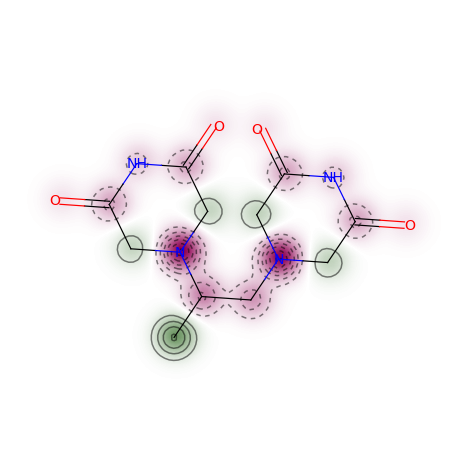

Dexrazoxane
score:0.5916270613670349


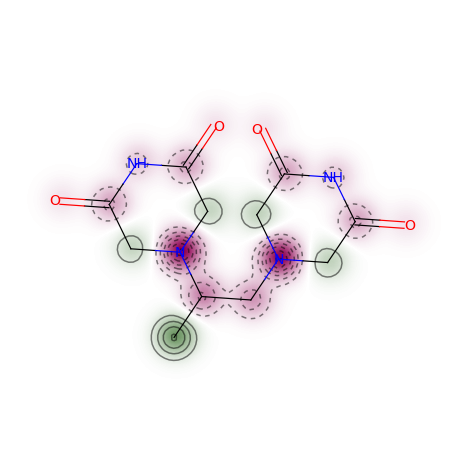

Acamprosate
score:0.7651118040084839


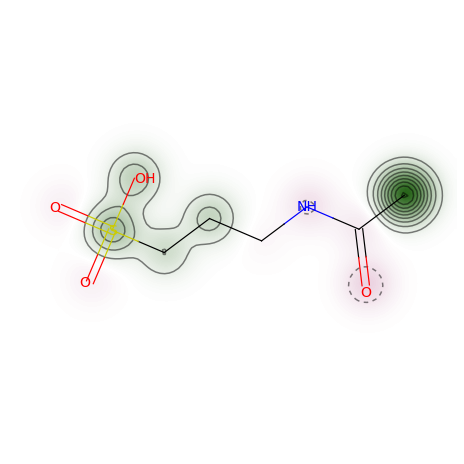

Gamolenic Acid
score:0.7746599912643433


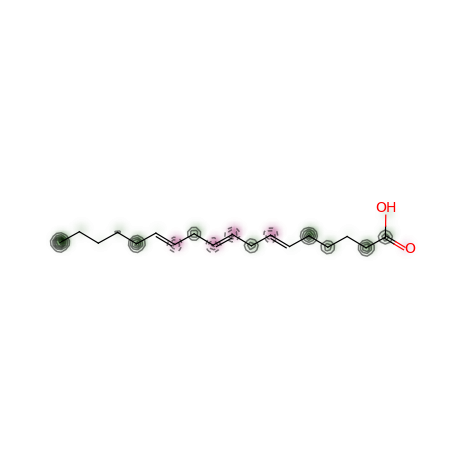

Potassium L-Lactate solution
score:0.7272113561630249


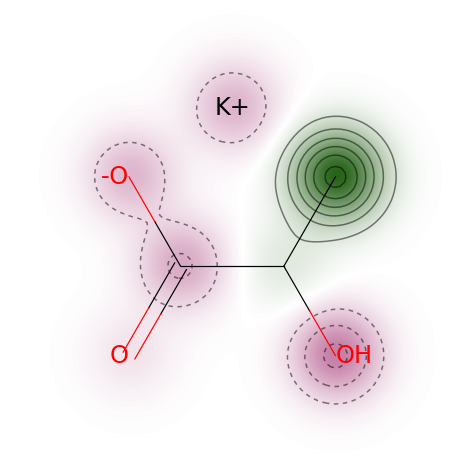

DL-Lactic Acid
score:0.7872893214225769


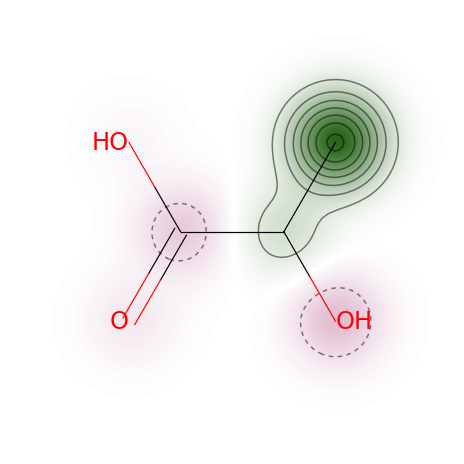

Dihydroxyacetone
score:0.7679009437561035


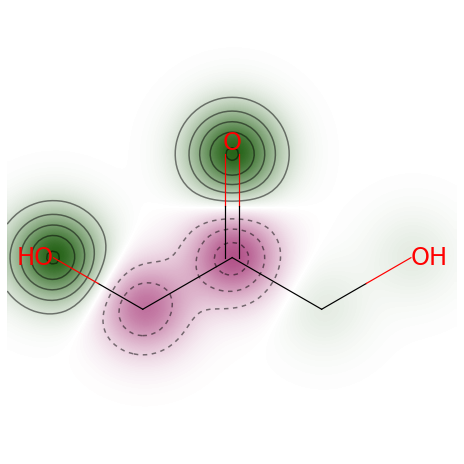

Hydroxyurea
score:0.5262872576713562


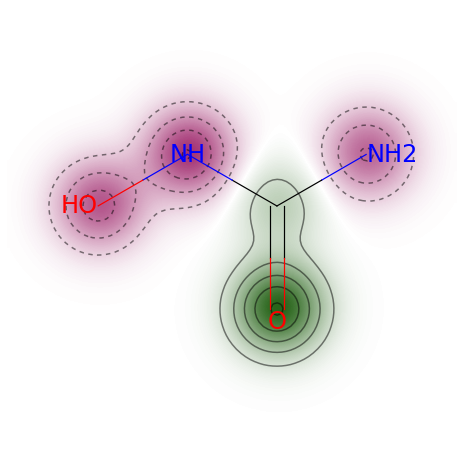

O-Acetyl-L-Carnitine Hydrochloride
score:0.8330243229866028


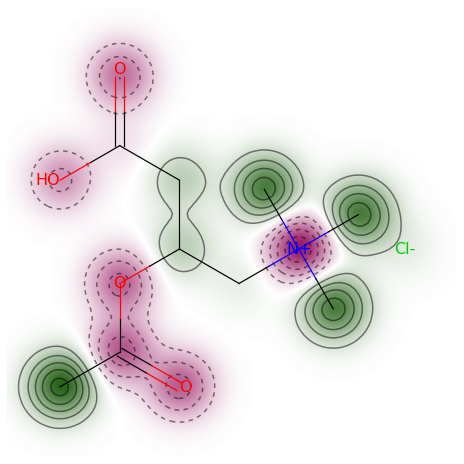

1 3-Thiazolidine-2 4-Dicarboxylicacid
score:0.6254072785377502


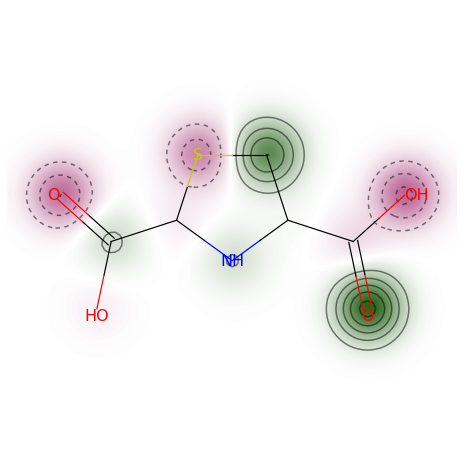

In [16]:
vis_contribs(
    neg_ff_amg_pred, 
    neg_amg_pred, 
    neg_frag_end_idxs, 
    valid_neg_data,
    num_vis=10
)

In [17]:
res_neg_data = valid_neg_data.copy()
res_neg_data.insert(2, 'p', neg_amg_pred)
res_neg_data_sorted = res_neg_data.sort_values(by=['p'], ascending=False)
check_training_data(amg_train_dataset, res_neg_data_sorted)

,Name,smiles,p
8,O-Acetyl-L-Carnitine Hydrochloride,CC(=O)OC(CC(=O)O)C[N+](C)(C)C.[Cl-],-2.000000
15,D-Minus-Penicillamine free base,CC(C)(S)C(N)C(=O)O,-2.000000
19,Lacosamide,COCC(NC(C)=O)C(=O)NCc1ccccc1,-2.000000
5,DL-Lactic Acid,CC(O)C(=O)O,-2.000000
17,Selenomethionine,C[Se]CCC(N)C(=O)O,-2.000000
3,Gamolenic Acid,CCCCCC=CCC=CCC=CCCCCC(=O)O,-2.000000
6,Dihydroxyacetone,O=C(CO)CO,-2.000000
2,Acamprosate,CC(=O)NCCCS(=O)(=O)O,0.765112
14,6-Aminocaproic Acid,NCCCCCC(=O)O,-2.000000
11,Vigabatrin,C=CC(N)CCC(=O)O,-2.000000


In [ ]:
fda_test_data = pd.read_csv('data/tl/FDA_tested_data-210723.csv')
valid_fda_test_features, valid_fda_test_data = featurize_data(
    fda_test_data, featurizer)

fda_test_loader = DataLoader([x.to_pyg_graph() for x in valid_fda_test_features], 
           batch_size=16, shuffle=False)
fda_test_pred = predict(amg_model, fda_test_loader)

In [ ]:
res_fda_test_data = valid_fda_test_data.copy()
res_fda_test_data.insert(2, 'p', fda_test_pred)
res_fda_test_data_sorted = res_fda_test_data.sort_values(by=['p'], ascending=False)
check_training_data(train_dataset, res_fda_test_data_sorted)

In [ ]:

img = Draw.MolsToGridImage(
    [m], molsPerRow=1, subImgSize=(200,200))
img